In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm
from scipy.integrate import cumulative_trapezoid
import time
import pickle
import os, glob

from joblib import Parallel, delayed, cpu_count

from efficient_fpt.models import DDModel, piecewise_const_func
from efficient_fpt.utils import get_alternating_mu_array

In [2]:
class aDDModel(DDModel):
    """
    One trial of an attentional drift diffusion model with alternating drift mu1 and mu2.
    """
    def __init__(self, mu1, mu2, sacc_array, flag, sigma, a, b, x0):
        super().__init__(x0)
        # drift parameters
        self.mu1 = mu1
        self.mu2 = mu2
        self.sacc_array = sacc_array
        self.flag = flag # indicates whether the process starts with mu1 (flag=0) or mu2 (flag=1)
        self.d = len(sacc_array) # number of stages
        self.mu_array = get_alternating_mu_array(mu1, mu2, self.d, flag)
        # diffusion parameter
        self.sigma = sigma
        # symmetric linear boundary parameters
        self.a = a
        self.b = b

    def drift_coeff(self, X: float, t: float) -> float:
        return piecewise_const_func(t, self.mu_array, self.sacc_array)

    def diffusion_coeff(self, X: float, t: float) -> float:
        return self.sigma

    @property
    def is_update_vectorizable(self) -> bool:
        return True

    def upper_bdy(self, t: float) -> float:
        return self.a - self.b * t

    def lower_bdy(self, t: float) -> float:
        return -self.a + self.b * t

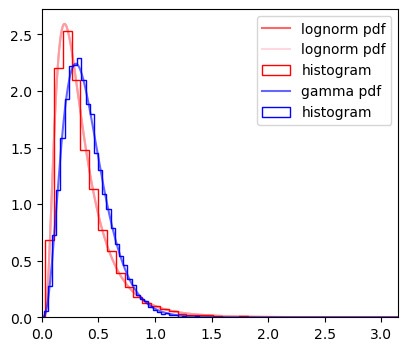

In [3]:
num_samples = 10000
rng = np.random.default_rng()
# sample lognormal waiting times and visualize
mu = 6.39
sigma = 0.63
waitTs1 = rng.lognormal(mean=mu, sigma=sigma, size=num_samples) / 2000

# sample gamma waiting times and visualize
shape_param = 4
scale_param = 0.1
waitTs2 = rng.gamma(shape_param, scale_param, num_samples)


fig, ax = plt.subplots(figsize=(10, 4))
x = np.linspace(0, max(np.max(waitTs1), np.max(waitTs2)), 2000)
ax.plot(x, lognorm.pdf(x, s=sigma, scale=np.exp(mu + np.log(1 / 2000))), "r", alpha=0.6, label="lognorm pdf")
ax.plot(x, lognorm.pdf(x / np.exp(mu + np.log(1 / 2000)), s=sigma) / np.exp(mu + np.log(1 / 2000)), "pink", alpha=0.6, label="lognorm pdf")
ax.hist(waitTs1, histtype="step", bins=40, color="red", density=True, label="histogram")
ax.plot(x, gamma.pdf(x, a=shape_param, scale=scale_param), "b", alpha=0.6, label="gamma pdf")
ax.hist(waitTs2, histtype="step", bins=40, color="blue", density=True, label="histogram")
ax.autoscale(tight=True, axis="x")
ax.set_aspect("equal")
ax.legend()
plt.show()

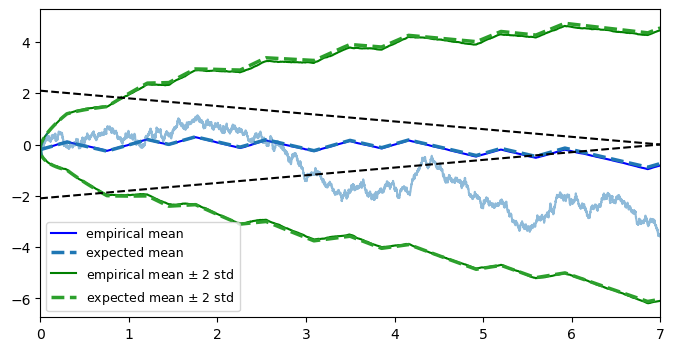

In [4]:
mu1, mu2 = 1.0, -0.8
a, b = 2.1, 0.3
T = a / b
x0 = -0.2

shape_param, scale_param = 4, 0.1
rng = np.random.default_rng()
fixations = rng.gamma(shape_param, scale_param, 1000)
sacc_array = np.insert(np.cumsum(fixations), 0, 0)
sacc_array = sacc_array[sacc_array < T]
flag = np.random.binomial(1, 0.5)
sigma = 1
num = 2000

ddm = aDDModel(mu1=mu1, mu2=mu2, sacc_array=sacc_array, flag=flag, sigma=sigma, a=a, b=b, x0=x0)
t_grid, X_grids = ddm.simulate_trajs(T=T, Nt=1000 * T, num=num)

expected_mean = cumulative_trapezoid(ddm.drift_coeff(_, t_grid), t_grid, initial=0) + x0
empirical_mean = np.mean(X_grids, axis=0)
expected_std = ddm.sigma * np.sqrt(t_grid)
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(t_grid, expected_mean, label="expected mean", linewidth=2.5, linestyle="--", c="tab:blue")
ax.plot(t_grid, empirical_mean + 2 * empirical_std, label=r"empirical mean $\pm$ 2 std", c="g")
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(t_grid, expected_mean + 2 * expected_std, label=r"expected mean $\pm$ 2 std", linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, expected_mean - 2 * expected_std, linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, X_grids[:1, :].T, alpha=0.5)
ax.plot(t_grid, ddm.upper_bdy(t_grid), c='k', linestyle="--")
ax.plot(t_grid, ddm.lower_bdy(t_grid), c='k', linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

In [5]:
def simulate_trial(
    n,
    eta,
    kappa,
    sigma,
    a,
    b,
    T,
    x0,
    shape_param,
    scale_param,
    min_gap=0.01,
    max_resamples=100,
    dt=1e-5,
):
    rng = np.random.default_rng()
    last_attempt_result = None  # fallback in case all attempts violate min_gap
    distinct_ratings = True
    for _ in range(max_resamples):
        # Sample saccade times on [0, T)
        fixations = rng.gamma(shape_param, scale_param, 1000)
        sacc_all = np.insert(np.cumsum(fixations), 0, 0.0)
        sacc_all = sacc_all[sacc_all < T]

        flag = rng.binomial(1, 0.5)
        r1 = rng.integers(1, 6)
        if distinct_ratings:
            r2 = rng.integers(1, 6)
            while r2 == r1:
                r2 = rng.integers(1, 6)
        else:
            r2 = rng.integers(1, 6)
        mu1 = kappa * (r1 - eta * r2)
        mu2 = kappa * (eta * r1 - r2)
        # print(f"r1={r1}, r2={r2}, eta={eta}, kappa={kappa}, mu1={mu1}, mu2={mu2}")

        addm = aDDModel(
            mu1=mu1,
            mu2=mu2,
            sacc_array=sacc_all,
            flag=flag,
            sigma=sigma,
            a=a,
            b=b,
            x0=x0,
        )
        decision = addm.simulate_fpt_datum(dt=dt)  # (rt, choice)
        rt = float(decision[0])

        # Saccades strictly before the decision time
        sacc_before_rt = sacc_all[sacc_all < rt]
        # (sacc_all includes 0.0, so size >= 1 unless rt<=0)
        last_sacc = float(sacc_before_rt[-1]) # if sacc_before_rt.size > 0 else 0.0
        gap = rt - last_sacc
        d = int(sacc_before_rt.size)
        mu_array = get_alternating_mu_array(mu1, mu2, d, flag)
        result_tuple = (decision, mu_array, sacc_before_rt, r1, r2, flag)
        if gap >= min_gap:
            return result_tuple  # accept trial
        else:
            last_attempt_result = result_tuple  # remember one to return if needed
    return last_attempt_result

In [6]:
a, b = 2, 0
T_max = 20
x0 = 0.5
kappa = 0.5
num_data = 30000
shape_param, scale_param = 4, 0.1

print("Available jobs (CPU cores):", cpu_count())


Available jobs (CPU cores): 96


In [7]:
out_dir = "tmp_datasets"
os.makedirs(out_dir, exist_ok=True)

pkl_files = []
for eta in 0.05 * np.arange(21):
    decision_data = np.zeros((num_data, 2))
    r1_data = np.zeros(num_data)
    r2_data = np.zeros(num_data)
    flag_data = np.zeros(num_data)
    mu_data = [None] * num_data
    sacc_data = [None] * num_data

    print(f"Simulating for eta={eta}...")
    start_time = time.time()
    results = Parallel(n_jobs=-1)(
        delayed(simulate_trial)(n, eta, kappa, sigma, a, b, T, x0, shape_param, scale_param)
        for n in range(num_data)
    )
    print(f"Elapsed time: {time.time() - start_time:.3f} seconds")
    # Store results
    for n, (decision, mu_array, sacc_array, r1, r2, flag) in enumerate(results):
        decision_data[n] = decision
        mu_data[n] = mu_array
        sacc_data[n] = sacc_array
        r1_data[n] = r1
        r2_data[n] = r2
        flag_data[n] = flag
    d_data = np.array([len(mu_array) for mu_array in mu_data])
    min_len, max_len, avg_len = np.min(d_data), np.max(d_data), np.mean(d_data)
    mu_data_padded = np.array([np.pad(mu_array, (0, max_len - len(mu_array)), mode='constant') for mu_array in mu_data])
    sacc_data_padded = np.array([np.pad(sacc_array, (0, max_len - len(sacc_array)), mode='constant') for sacc_array in sacc_data])
    data_to_save = {
        'mu_array_padded_data': mu_data_padded,
        'sacc_array_padded_data': sacc_data_padded,
        'd_data': d_data,
        'decision_data': decision_data,
        'r1_data': r1_data,
        'r2_data': r2_data,
        'flag_data': flag_data.astype(np.int32),
        'eta': eta,
        'kappa': kappa,
        'sigma': sigma,
        'a': a,
        'b': b,
        'x0': x0,
        'T': T_max,
        'gamma_shape_param': shape_param,
        'gamma_scale_param': scale_param
    }
    fname = os.path.join(out_dir, "addm_data_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl")
    with open(fname, "wb") as f:
        pickle.dump(data_to_save, f)
    pkl_files.append(fname)
    print(f"  -> saved {fname}")

Simulating for eta=0.0...
Elapsed time: 2506.978 seconds
  -> saved tmp_datasets/addm_data_20260207-120813.pkl
Simulating for eta=0.05...
Elapsed time: 2489.675 seconds
  -> saved tmp_datasets/addm_data_20260207-124943.pkl
Simulating for eta=0.1...
Elapsed time: 2487.276 seconds
  -> saved tmp_datasets/addm_data_20260207-133111.pkl
Simulating for eta=0.15000000000000002...
Elapsed time: 2505.284 seconds
  -> saved tmp_datasets/addm_data_20260207-141257.pkl
Simulating for eta=0.2...
Elapsed time: 2498.120 seconds
  -> saved tmp_datasets/addm_data_20260207-145436.pkl
Simulating for eta=0.25...
Elapsed time: 2506.376 seconds
  -> saved tmp_datasets/addm_data_20260207-153623.pkl
Simulating for eta=0.30000000000000004...
Elapsed time: 2455.517 seconds
  -> saved tmp_datasets/addm_data_20260207-161719.pkl
Simulating for eta=0.35000000000000003...
Elapsed time: 2482.009 seconds
  -> saved tmp_datasets/addm_data_20260207-165841.pkl
Simulating for eta=0.4...
Elapsed time: 2438.235 seconds
  -> 

In [ ]:
# If pkl_files wasn't built by the generation cell above, scan the folder
if "pkl_files" not in dir() or not pkl_files:
    pkl_files = sorted(glob.glob("tmp_datasets/addm_data_*.pkl"))
    # Exclude any already-combined file
    pkl_files = [f for f in pkl_files if "all_eta" not in f]
    print(f"Found {len(pkl_files)} individual pkl files in current directory")

# Pack all individual pkl files into a single pkl, then delete the intermediates
all_data = {}
for fpath in pkl_files:
    with open(fpath, "rb") as f:
        d = pickle.load(f)
    eta_key = float(d["eta"])
    all_data[eta_key] = d
    print(f"  loaded eta={eta_key:.4f} from {fpath}")

combined_fname = "addm_data_all_eta_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
with open(combined_fname, "wb") as f:
    pickle.dump(all_data, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"\nSaved {len(all_data)} eta runs -> {combined_fname}")

# Remove intermediate files
for fpath in pkl_files:
    os.remove(fpath)
    print(f"  deleted {fpath}")
if os.path.isdir(out_dir) and not os.listdir(out_dir):
    os.rmdir(out_dir)
    print(f"Deleted empty folder: {out_dir}")
print("Done.")

  loaded eta=0.0000 from tmp_datasets/addm_data_20260207-120813.pkl
  loaded eta=0.0500 from tmp_datasets/addm_data_20260207-124943.pkl
  loaded eta=0.1000 from tmp_datasets/addm_data_20260207-133111.pkl
  loaded eta=0.1500 from tmp_datasets/addm_data_20260207-141257.pkl
  loaded eta=0.2000 from tmp_datasets/addm_data_20260207-145436.pkl
  loaded eta=0.2500 from tmp_datasets/addm_data_20260207-153623.pkl
  loaded eta=0.3000 from tmp_datasets/addm_data_20260207-161719.pkl
  loaded eta=0.3500 from tmp_datasets/addm_data_20260207-165841.pkl
  loaded eta=0.4000 from tmp_datasets/addm_data_20260207-173920.pkl
  loaded eta=0.4500 from tmp_datasets/addm_data_20260207-182006.pkl
  loaded eta=0.5000 from tmp_datasets/addm_data_20260207-190019.pkl
  loaded eta=0.5500 from tmp_datasets/addm_data_20260207-194029.pkl
  loaded eta=0.6000 from tmp_datasets/addm_data_20260207-202034.pkl
  loaded eta=0.6500 from tmp_datasets/addm_data_20260207-205954.pkl
  loaded eta=0.7000 from tmp_datasets/addm_data_